# SWI - single layer

Test case - strange behaviour output control package
When requesting both budget and head data via the OC package, the solution 
differs from when only the head is requested.

This is set via the 'words' parameter in the OC package.

In [15]:
%matplotlib inline
import os
import sys
import numpy as np
import flopy.modflow as mf
import flopy.utils as fu
import matplotlib.pyplot as plt

In [16]:
os.chdir('C:\\Users\\Bas\\Google Drive\\USGS\\FloPy\\slope1D')
sys.path.append('C:\\Users\\Bas\\Google Drive\\USGS\\FloPy\\basScript') # location of gridObj

modelname 	= 'run1swi2'
exe_name 	= 'mf2005'
workspace 	= 'data'

In [17]:
ml = mf.Modflow(modelname, exe_name=exe_name, model_ws=workspace)

In [18]:
nstp    = 10000	     #[]
perlen  = 10000	     #[d]
ssz     = 0.2 	     #[]
Q       = 0.005      #[m3/d]

In [19]:
nlay = 1
nrow = 1
ncol = 4
delr = 1.
delc = 1.
dell = 1.

top = np.array([[-1.,-1., -0.7, -0.4]], dtype = np.float32)
bot = np.array(top-dell, dtype = np.float32).reshape((nlay,nrow,ncol))
initWL = 0. # inital water level

In [20]:
lrcQ1 = np.recarray(1, dtype = mf.ModflowWel.get_default_dtype())
lrcQ1[0] = (0, 0, ncol-1, Q) #LRCQ, Q[m**3/d]

In [21]:
lrchc = np.recarray(2, dtype = mf.ModflowGhb.get_default_dtype())
lrchc[0]=(0, 0, 0, -top[0,0]*0.025, 0.8 / 2.0 * delc)
lrchc[1]=(0, 0, 1, -top[0,0]*0.025, 0.8 / 2.0 * delc)

In [22]:
lrchd = np.recarray(2, dtype = mf.ModflowChd.get_default_dtype())
lrchd[0]=(0, 0, 0, -top[0,0]*0.025, -top[0,0]*0.025)
lrchd[1]=(0, 0, 1, -top[0,0]*0.025, -top[0,0]*0.025)

In [23]:
zini = -0.9*np.ones((nrow,ncol))
isource = np.array([[-2,-2, 0, 0]])

In [24]:
ml = mf.Modflow(modelname, version='mf2005', exe_name=exe_name)
discret = mf.ModflowDis(ml, nrow=nrow, ncol=ncol, nlay=nlay, delr=delr, delc=delc,
                        laycbd=[0], top=top, botm=bot,
                        nper=1, perlen=perlen, nstp=nstp)
bas = mf.ModflowBas(ml, ibound=1, strt=(initWL-zini)*0.025)
bcf = mf.ModflowBcf(ml, laycon=[0], tran=[4.0])
wel = mf.ModflowWel(ml, stress_period_data={0:lrcQ1})
#ghb = mf.ModflowGhb(ml, stress_period_data={0:lrchc})
chd = mf.ModflowChd(ml, stress_period_data={0:lrchd})
swi = mf.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=0.02, tipslope=0.04, nu=[0, 0.025],
                     zeta=[zini], ssz=ssz, isource=isource, nsolver=1)
oc  = mf.ModflowOc(ml,save_head_every=nstp)
pcg = mf.ModflowPcg(ml)

In [25]:
ml.write_input() #--write the model files
m = ml.run_model(silent=True, report=True)

In [26]:
headfile = modelname + '.hds'
hdobj = fu.HeadFile(headfile)
head = hdobj.get_data(idx=0)

zetafile = modelname + '.zta'
zobj = fu.CellBudgetFile(zetafile)
zeta = zobj.get_data(idx=0, text='      ZETASRF  1')[0]

In [27]:
print 'isource:        ', swi.isource.array
print 'init zeta:      ', swi.zeta[0].array
print 'init fresh hd:  ', bas.strt.array
print 'final head:     ', head[0, 0, :]
print 'final zeta:     ', zeta[0,0,:]
print 'final BGH head: ', - 40. * (head[0, 0, :])

isource:         [[[-2 -2  0  0]]]
init zeta:       [[[-0.89999998 -0.89999998 -0.89999998 -0.89999998]]]
init fresh hd:   [[[ 0.0225  0.0225  0.0225  0.0225]]]
final head:      [ 0.025       0.025       0.03000002  0.03182106]
final zeta:      [-1.         -1.00000048 -1.20000172 -1.27284384]
final BGH head:  [-1.         -1.         -1.20000076 -1.27284229]


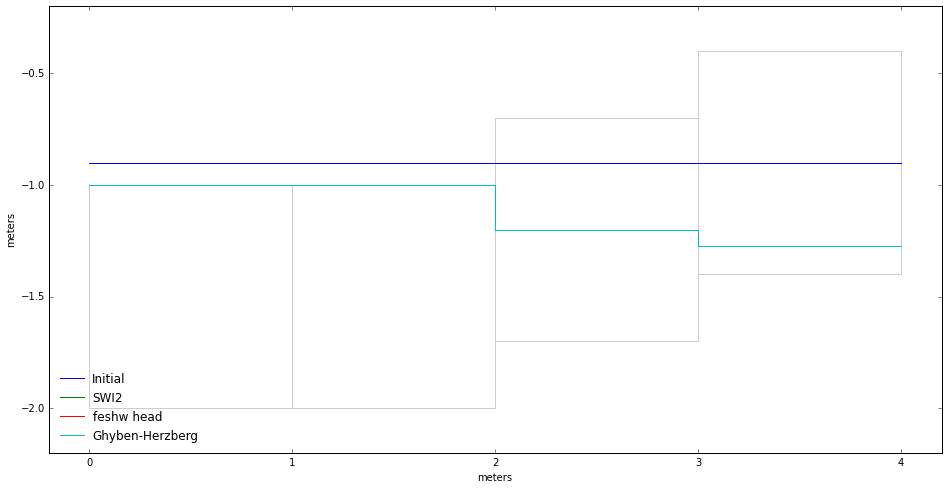

In [28]:
import gridobj as grd
gr = grd.gridobj(discret)

fig = plt.figure(figsize=(16, 8), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
gr.plotgrLC(ax)
gr.plothdLC(ax,zini[0,:],label='Initial')
gr.plothdLC(ax,zeta[0,0,:], label='SWI2')
gr.plothdLC(ax,head[0, 0, :], label='feshw head')
gr.plothdLC(ax,-40. * (head[0, 0, :]), label='Ghyben-Herzberg')

ax.axis(gr.limLC([-0.2,0.2,-0.2,0.2]))
leg = ax.legend(loc='lower left', numpoints=1)
leg._drawFrame = False

                      VOLUMETRIC SWI ZONE BUDGET FOR ENTIRE MODEL
                     AT END OF TIME STEP10000 IN STRESS PERIOD   1
                                      ZONE     1
  -----------------------------------------------------------------------------------

        CUMULATIVE VOLUMES      L**3       RATES FOR THIS TIME STEP      L**3/T
        ------------------                 ------------------------

              IN:                                      IN:
              ---                                      ---
             BOUNDARIES =          50.0015            BOUNDARIES =       5.0000E-03
          CONSTANT HEAD =           0.0000         CONSTANT HEAD =           0.0000
            ZONE CHANGE =       2.0018E-02           ZONE CHANGE =           0.0000
       ZONE CHG TIP/TOE =       5.9999E-03      ZONE CHG TIP/TOE =           0.0000
            ZONE MIXING =           0.0000           ZONE MIXING =           0.0000

               TOTAL IN =          50.0275              TOTAL IN =       5.0000E-03

             OUT:                                     OUT:
             ----                                     ----
             BOUNDARIES =           0.0000            BOUNDARIES =           0.0000
          CONSTANT HEAD =          49.8714         CONSTANT HEAD =       5.0000E-03
            ZONE CHANGE =           0.1546           ZONE CHANGE =           0.0000
       ZONE CHG TIP/TOE =       5.9999E-03      ZONE CHG TIP/TOE =           0.0000
            ZONE MIXING =           0.0000           ZONE MIXING =           0.0000

              TOTAL OUT =          50.0320             TOTAL OUT =       5.0000E-03

               IN - OUT =      -4.5395E-03              IN - OUT =       9.3132E-10

    PERCENT DISCREPANCY =          -0.01     PERCENT DISCREPANCY =           0.00



                      VOLUMETRIC SWI ZONE BUDGET FOR ENTIRE MODEL
                     AT END OF TIME STEP10000 IN STRESS PERIOD   1
                                      ZONE     2
  -----------------------------------------------------------------------------------

        CUMULATIVE VOLUMES      L**3       RATES FOR THIS TIME STEP      L**3/T
        ------------------                 ------------------------

              IN:                                      IN:
              ---                                      ---
             BOUNDARIES =           0.0000            BOUNDARIES =           0.0000
          CONSTANT HEAD =           0.0000         CONSTANT HEAD =           0.0000
            ZONE CHANGE =           0.1546           ZONE CHANGE =           0.0000
       ZONE CHG TIP/TOE =       1.8834E-02      ZONE CHG TIP/TOE =           0.0000
            ZONE MIXING =           0.0000           ZONE MIXING =           0.0000

               TOTAL IN =           0.1734              TOTAL IN =           0.0000

             OUT:                                     OUT:
             ----                                     ----
             BOUNDARIES =           0.0000            BOUNDARIES =           0.0000
          CONSTANT HEAD =           0.1300         CONSTANT HEAD =           0.0000
            ZONE CHANGE =       3.2853E-02           ZONE CHANGE =           0.0000
       ZONE CHG TIP/TOE =       5.9999E-03      ZONE CHG TIP/TOE =           0.0000
            ZONE MIXING =           0.0000           ZONE MIXING =           0.0000

              TOTAL OUT =           0.1689             TOTAL OUT =           0.0000

               IN - OUT =       4.5692E-03              IN - OUT =           0.0000

    PERCENT DISCREPANCY =           2.67     PERCENT DISCREPANCY =           0.00


 HEAD WILL BE SAVED ON UNIT   51 AT END OF TIME STEP10000, STRESS PERIOD    1
1
  VOLUMETRIC BUDGET FOR ENTIRE MODEL AT END OF TIME STEP10000, STRESS PERIOD   1
  ------------------------------------------------------------------------------

     CUMULATIVE VOLUMES      L**3       RATES FOR THIS TIME STEP      L**3/T
     ------------------                 ------------------------

           IN:                                      IN:
           ---                                      ---
             STORAGE =           0.0000               STORAGE =           0.0000
       CONSTANT HEAD =       1.4306E-02         CONSTANT HEAD =           0.0000
               WELLS =          50.0015                 WELLS =       5.0000E-03
          SWIADDTOCH =         149.7491            SWIADDTOCH =       1.5000E-02

            TOTAL IN =         199.7649              TOTAL IN =       2.0000E-02

          OUT:                                     OUT:
          ----                                     ----
             STORAGE =           0.0000               STORAGE =           0.0000
       CONSTANT HEAD =         199.7248         CONSTANT HEAD =       2.0000E-02
               WELLS =           0.0000                 WELLS =           0.0000
          SWIADDTOCH =       4.9679E-02            SWIADDTOCH =           0.0000

           TOTAL OUT =         199.7745             TOTAL OUT =       2.0000E-02

            IN - OUT =      -9.6436E-03              IN - OUT =           0.0000

 PERCENT DISCREPANCY =          -0.00     PERCENT DISCREPANCY =           0.00